In [21]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid

In [47]:
class SocialNetworkAgent(Agent):
    """Agent class models agent behavior individually"""
    def __init__(self, unique_id, model, interaction, option):
        super().__init__(unique_id, model)
        self.engagement_threshold = random.uniform(0, 1)
        self.interaction = interaction
        self.traits = [random.choice([0, 1]) for _ in range(2)]  # List of 2 binary traits
        self.option = option

    def step(self):
        self.agent_behavior()

    def agent_behavior(self):
        """Follower behavior called each iteration for follower agents"""
        if self.interaction == "random":
            neighbors = list(self.model.G.neighbors(self.unique_id))
            if neighbors:
                target = random.choice(neighbors)
                if random.random() < self.engagement_threshold:
                    self.model.add_directed_connection(self.unique_id, target)

        elif self.interaction == "extended":
            self.extended_interaction()
            
    def targeted_recommendation(self):
        """Calculate targeted recommendation with probability based on homogeneity (i.e. similar traits)
        and shortest pathlength"""
        G = self.model.G
        follower_node = self.unique_id
        follower_traits = self.traits

        # Calculate recommendation scores
        recommendation_scores = {}
        for influencer_node in G.nodes():
            if influencer_node != follower_node:
                influencer_traits = G.nodes[influencer_node]['agent'].traits
                try:
                    shortest_path_length = nx.shortest_path_length(G, source=follower_node, target=influencer_node)
                except nx.NetworkXNoPath:
                    continue  # Skip this influencer if no path exists
                homogeneity = sum([1 if follower_traits[i] == influencer_traits[i] else 0 for i in range(2)]) / 2
                
                # Use a combination of shortest_path_length and homogeneity for recommendation score
                recommendation_score = shortest_path_length * homogeneity
                recommendation_scores[influencer_node] = recommendation_score

        # Normalize recommendation scores
        total_score = sum(recommendation_scores.values())
        normalized_scores = {k: v / total_score for k, v in recommendation_scores.items()} if total_score > 0 else {}

        if normalized_scores:
            chosen_influencer = random.choices(list(normalized_scores.keys()), weights=list(normalized_scores.values()), k=1)
        else:
            chosen_influencer = None

        return chosen_influencer

    def extended_interaction(self):
        """Choose interaction algorithm"""
        if self.option == 1:
            self.make_directional_connection()
        elif self.option == 2:
            self.ask_for_recommendation_with_random_loss()
        elif self.option == 3:
            self.ask_for_recommendation_with_certain_loss()

    def make_directional_connection(self):
        """Makes connection with neighbor of neighbor node if not yet present"""
        neighbors = list(self.model.G.neighbors(self.unique_id))
        potential_targets = set()
        for neighbor in neighbors:
            potential_targets.update(self.model.G.neighbors(neighbor))

        potential_targets = list(potential_targets)
        if potential_targets:
            target = random.choice(potential_targets)
            if not self.model.G.has_edge(self.unique_id, target):
                self.model.add_directed_connection(self.unique_id, target)
            else:
            
                self.connect_to_random_node()
        else:
        
            self.connect_to_random_node()
            
    def connect_to_random_node(self):
        """Connects node to random node"""
        possible_targets = [node for node in self.model.G.nodes if node != self.unique_id]
        target = random.choice(possible_targets)
        if not self.model.G.has_edge(self.unique_id, target):
            self.model.add_directed_connection(self.unique_id, target)

    def ask_for_recommendation_with_certain_loss(self):
        """Requests a recommendation and updates connections with certain loss.

        Chooses an influencer based on a recommendation score. If an influencer is chosen
        and the agent has incoming edges, replaces existing connections with the influencer
        if the new recommendation offers higher engagement. """
        
        chosen_influencer = self.targeted_recommendation()
        if chosen_influencer:
            chosen_influencer = chosen_influencer[0]
            in_edges = list(self.model.G.in_edges(self.unique_id, data=True))
            if in_edges:
                for edge in in_edges:
                    if self.model.G.has_edge(chosen_influencer, self.unique_id):
                        if edge[2]['engagement'] < self.model.G[chosen_influencer][self.unique_id]['engagement']:
                            self.model.G.remove_edge(edge[0], self.unique_id)
                            self.model.G.add_edge(chosen_influencer, self.unique_id, engagement=random.random())
                            break


    def ask_for_recommendation_with_random_loss(self):
        """Requests a recommendation and updates connections with random loss.
        
        Chooses an influencer based on a recommendation score. If an influencer is chosen
        and the agent has incoming edges, replaces the edge with the lowest engagement
        with a new connection to the influencer with a random engagement value."""
        
        chosen_influencer = self.targeted_recommendation()
        if chosen_influencer:
            chosen_influencer = chosen_influencer[0]
            in_edges = list(self.model.G.in_edges(self.unique_id, data=True))
            if in_edges:
                lowest_engagement_edge = min(in_edges, key=lambda x: x[2]['engagement'])
                if random.random() < self.engagement_threshold:
                    self.model.G.remove_edge(lowest_engagement_edge[0], self.unique_id)
                    self.model.G.add_edge(chosen_influencer, self.unique_id, engagement=random.random())


class SocialNetworkModel(Model):
    """Social network model class models the interaction between agents"""
    def __init__(self, num_agents, initial_p, interaction="random", option=1):
        super().__init__()
        self.num_agents = num_agents
        self.schedule = RandomActivation(self)
        self.initial_p = initial_p

        self.create_random_network()
        
        # Check if graph is strongy connected, if not take the strongly connected part and use as total
        if not nx.is_strongly_connected(self.G):
            components = list(nx.strongly_connected_components(self.G))
            largest_component = max(components, key=len)
            self.G = self.G.subgraph(largest_component).copy()
        
        # Initialize grid using mesa.space.NetworkGrid
        self.grid = NetworkGrid(self.G)
        
        # Add agents in each node, note each agent has node=unique_id
        for i, node in enumerate(self.G.nodes()):
            agent = SocialNetworkAgent(node, self, interaction, option)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)
            self.G.nodes[node]['agent'] = agent  # Store the agent in the node attributes
            

        self.data_collector = {"avg_out_degree": [], "avg_in_degree": [],
                               "avg_clustering_coeff": [], "avg_path_length": [],
                               "homogeneity": []}

    def create_random_network(self):
        """Initiate random network with bi-directed edges including 
        random engagement value U(0,1)"""
        self.G = nx.DiGraph()
        undirected_G = nx.erdos_renyi_graph(n=self.num_agents, p=self.initial_p)
        for u, v in undirected_G.edges():
            # Add directed edges when initializing graph, engagement value in each direction
            self.G.add_edge(u, v, engagement=random.random())
            self.G.add_edge(v, u, engagement=random.random())

    def add_directed_connection(self, from_node, to_node):
        """Add directed connections between nodes"""
        if not self.G.has_edge(from_node, to_node):
            self.G.add_edge(from_node, to_node, engagement=random.random())

    def get_mean_in_degree(self):
        """Calculate the mean in-degree of network"""
        degrees = [val for (node, val) in self.G.in_degree()]
        mean_degree = sum(degrees) / len(degrees)
        return mean_degree

    def step(self):
        """Steps in the simulation"""
        if not nx.is_strongly_connected(self.G):
            raise nx.NetworkXError("Graph is not strongly connected.")
        self.schedule.step()
        self.track_metrics()
        self.prune_network()

    def track_metrics(self):
        """Tracking metrics over network"""
        avg_out_degree = sum(dict(self.G.out_degree()).values()) / self.num_agents
        avg_in_degree = sum(dict(self.G.in_degree()).values()) / self.num_agents
        avg_clustering_coeff = nx.average_clustering(self.G)
        avg_path_length = nx.average_shortest_path_length(self.G)
        homogeneity = self.calculate_homogeneity()

        self.data_collector["avg_out_degree"].append(avg_out_degree)
        self.data_collector["avg_in_degree"].append(avg_in_degree)
        self.data_collector["avg_clustering_coeff"].append(avg_clustering_coeff)
        self.data_collector["avg_path_length"].append(avg_path_length)
        self.data_collector["homogeneity"].append(homogeneity)

    def calculate_homogeneity(self):
        """Calculates homogeneity over network"""
        total_similarity = 0
        count = 0
        for u, v in self.G.edges():
            agent_u = self.G.nodes[u]['agent']
            agent_v = self.G.nodes[v]['agent']
            similarity = sum([1 if agent_u.traits[i] == agent_v.traits[i] else 0 for i in range(2)]) / 2
            total_similarity += similarity
            count += 1
        return total_similarity / count if count > 0 else 0

    def prune_network(self):
        """Prunes network by modulo of number of agents 
        (if pruned by a percentage, network dies out very soon)"""
        edges = list(self.G.edges())
        num_edges_to_remove = len(edges) // self.num_agents
        edges_to_remove = random.sample(edges, num_edges_to_remove)
        self.G.remove_edges_from(edges_to_remove)



In [55]:
# Running the model
model = SocialNetworkModel(num_agents=200, initial_p=0.5, interaction="extended", option=3)
for i in range(50):
    model.step()
    pos = nx.spring_layout(model.G)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


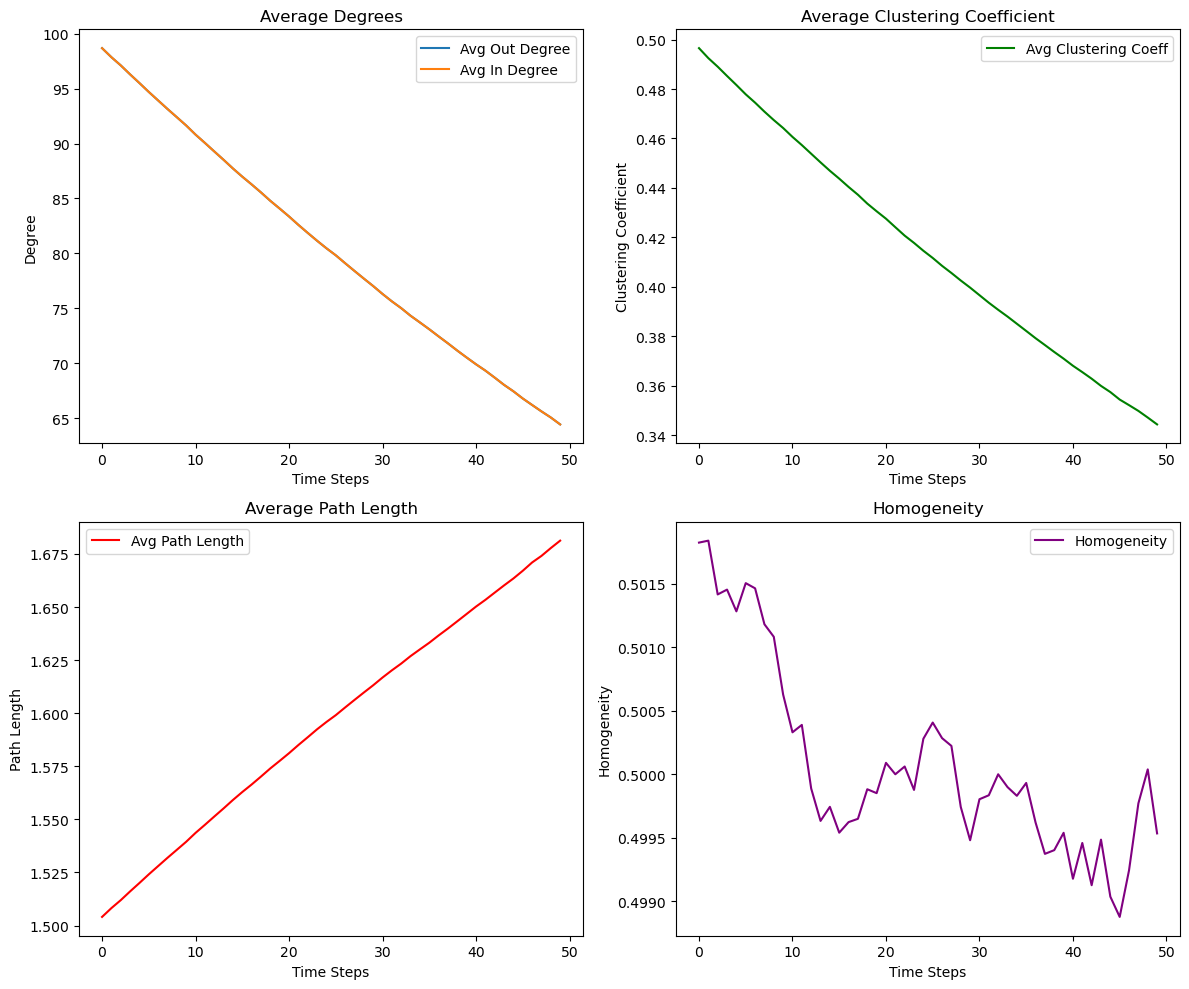

In [56]:
import matplotlib.pyplot as plt

# Create a figure with 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Avg Out Degree and Avg In Degree together in the first subplot
axs[0, 0].plot(model.data_collector["avg_out_degree"], label="Avg Out Degree")
axs[0, 0].plot(model.data_collector["avg_in_degree"], label="Avg In Degree")
axs[0, 0].set_title("Average Degrees")
axs[0, 0].set_xlabel("Time Steps")
axs[0, 0].set_ylabel("Degree")
axs[0, 0].legend()

# Plot Avg Clustering Coefficient in the second subplot
axs[0, 1].plot(model.data_collector["avg_clustering_coeff"], label="Avg Clustering Coeff", color='green')
axs[0, 1].set_title("Average Clustering Coefficient")
axs[0, 1].set_xlabel("Time Steps")
axs[0, 1].set_ylabel("Clustering Coefficient")
axs[0, 1].legend()

# Plot Avg Path Length in the third subplot
axs[1, 0].plot(model.data_collector["avg_path_length"], label="Avg Path Length", color='red')
axs[1, 0].set_title("Average Path Length")
axs[1, 0].set_xlabel("Time Steps")
axs[1, 0].set_ylabel("Path Length")
axs[1, 0].legend()

# Plot Homogeneity in the fourth subplot
axs[1, 1].plot(model.data_collector["homogeneity"], label="Homogeneity", color='purple')
axs[1, 1].set_title("Homogeneity")
axs[1, 1].set_xlabel("Time Steps")
axs[1, 1].set_ylabel("Homogeneity")
axs[1, 1].legend()

# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()
